In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

/opt/conda/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


# Initialization
## Hyperparameters for discovery

In [2]:
adsorbate = 'CO'
target_energy = -0.67
initial_training_size = 1000
batch_size = 200
quantile_cutoff = 0.95

## Gather validation data

In [3]:
import random
import ase.db


db_dir = '../../pull_data/%s/' % adsorbate
db = ase.db.connect(db_dir + '%s.db' % adsorbate)
rows = list(db.select())
random.Random(42).shuffle(rows)


def parse_rows(rows):
    features = []
    labels = []
    surfaces = []

    for row in rows:
        features.append(row.id)
        data = row.data
        labels.append(data['adsorption_energy'])
        surface = (data['mpid'], data['miller'], data['shift'], data['top'])
        surfaces.append(surface)

    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

# Hallucinate
## Initialize

In [4]:
import os
os.environ['PYTHONPATH'] = '/home/jovyan/GASpy:/home/jovyan/GASpy/GASpy_regressions:'

import sys
sys.path.insert(0, '/home/jovyan/GASpy')
sys.path.insert(0, '/home/jovyan/GASpy/GASpy_regressions')

sys.path.append('../../..')
from src.discoverers.adsorption.mms import MultiscaleDiscoverer
from src.discoverers.adsorption.models import CFGP
from src.discoverers.adsorption.values import calc_co2rr_activities


# Initialize
model = CFGP(db_dir)
discoverer = MultiscaleDiscoverer(model=model,
                                  value_calculator=calc_co2rr_activities,
                                  quantile_cutoff=quantile_cutoff,
                                  batch_size=batch_size,
                                  training_features=training_features,
                                  training_labels=training_labels,
                                  training_surfaces=training_surfaces,
                                  sampling_features=sampling_features,
                                  sampling_labels=sampling_labels,
                                  sampling_surfaces=sampling_surfaces,
                                  init_train=False  # Set to `False` only for warm starts
                                 )

### Loaded preprocessed data from:  ['../../pull_data/CO/data.pt']


## Run

In [5]:
# Or load the last run
discoverer.load_last_run()

../../../src/discoverers/adsorption/base.py:812: UserWarning: Tried to set the bulk_values attribute when loading but couldn't
  warnings.warn("Tried to set the %s attribute when loading but couldn't" % key)


cmd:
  checkpoint_dir: /home/jovyan/catalyst-acquisitions/notebooks/MMS/CFGP/checkpoints/2021-01-10-02-22-24-cnn
  identifier: cnn
  logs_dir: /home/jovyan/catalyst-acquisitions/notebooks/MMS/CFGP/logs/tensorboard/2021-01-10-02-22-24-cnn
  print_every: 100
  results_dir: /home/jovyan/catalyst-acquisitions/notebooks/MMS/CFGP/results/2021-01-10-02-22-24-cnn
  seed: null
  timestamp: 2021-01-10-02-22-24-cnn
dataset:
  src: ../../pull_data/CO/
  test_size: 0
  train_size: 1
  val_size: 0
logger: tensorboard
model: cgcnn
model_attributes:
  atom_embedding_size: 64
  fc_feat_size: 128
  num_fc_layers: 4
  num_graph_conv_layers: 6
  regress_forces: false
optim:
  batch_size: 64
  lr_gamma: 0.1
  lr_initial: 0.001
  lr_milestones:
  - 25
  - 45
  max_epochs: 50
  num_gpus: 2
  warmup_epochs: 10
  warmup_factor: 0.2
task:
  dataset: gasdb
  description: Regression of DFT calculated binding energes
  labels:
  - binding energy
  metric: mae
  type: regression

### Loading dataset: gasdb
### Load

## Analyze

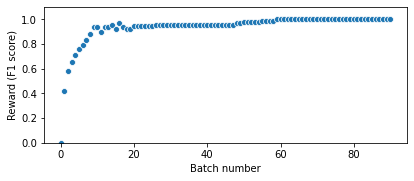

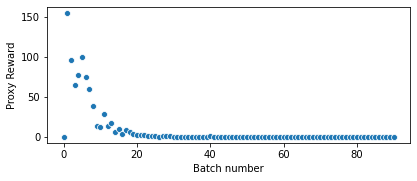

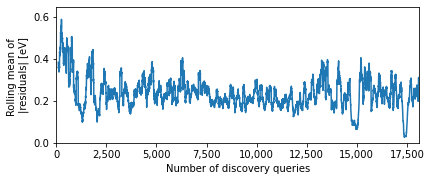

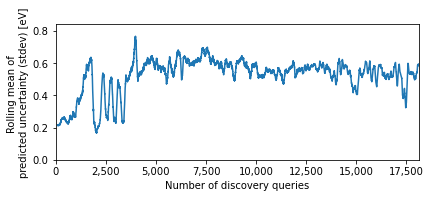

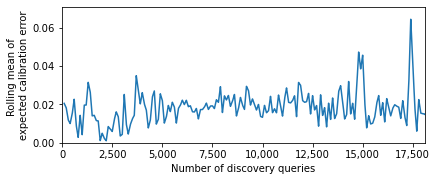

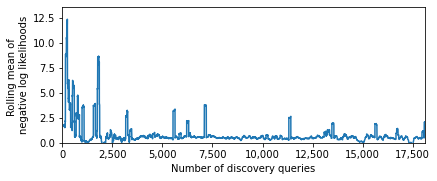

In [63]:
reward_fig, proxy_fig, accuracy_fig, uncertainty_fig, calibration_fig, nll_fig = discoverer.plot_performance(window=100)

# Calculate $\Delta \hat{F}$

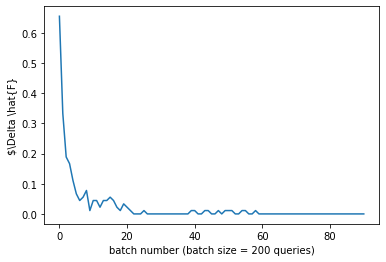

In [58]:
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


# Find all the caches
folder = 'MultiscaleDiscoverer_CFGP_caches'
cache_files = [cache for cache in os.listdir(folder)
               if cache.endswith('.pkl')]
cache_files.sort()

# Open all the caches
values = []
for cache_name in tqdm(cache_files):
    cache_file = os.path.join(folder, cache_name)
    with open(cache_file, 'rb') as file_handle:
        cache = pickle.load(file_handle)

    # Save all the bulk values
    try:
        values.append(cache['bulk_values'])
    except KeyError:
        continue

# Calculate out the classification history
classify_bulks = discoverer._classify_bulks
bulk_classes = [classify_bulks(_values) for _values in values]

# Initialize the algorithm
dFhat_history = []
for i, previous_classes in enumerate(bulk_classes[:-1]):
    classes = bulk_classes[i+1]
    a, b, c, d = (0, 0, 0, 0)

    # Count a, b, and c to...
    for mpid, class_ in classes.items():
        previous_class = previous_classes[mpid]
        if previous_class is True:
            if class_ is True:
                a += 1
            elif class_ is False:
                b += 1
        elif previous_class is False:
            if class_ is True:
                c += 1

    # Calculate and store dFhat values
    dFhat = 1 - 2*a / (2*a + b + c)
    dFhat_history.append(dFhat)
dFhat_history = np.array(dFhat_history)

# Plot
ax_df = sns.lineplot(list(range(len(dFhat_history))), dFhat_history)
_ = ax_df.set_xlabel('batch number (batch size = 200 queries)')
_ = ax_df.set_ylabel('$\Delta \hat{F}')

# Make a figure for the paper

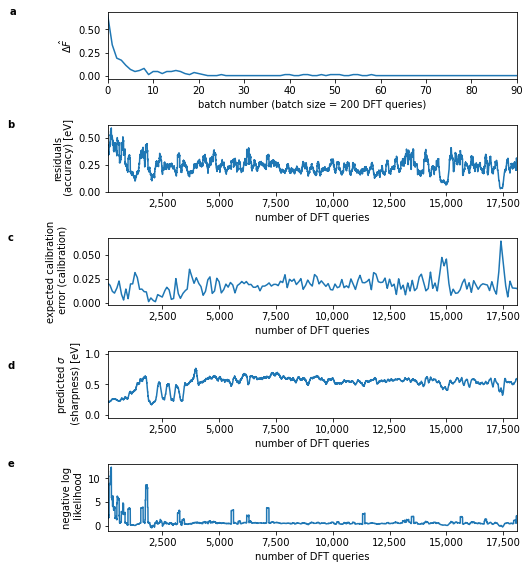

In [91]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns


FORMATTER = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

# Initialize final figure
fig, axes = plt.subplots(5, figsize=(7.5, 8))

# Define the figures we want to grab for the big one
figs = {('a', 'batch number (batch size = 200 DFT queries)', '$\Delta \hat{F}$'): ax_df.figure,
        ('b', 'number of DFT queries', 'residuals\n (accuracy) [eV]'): accuracy_fig,
        ('c', 'number of DFT queries', 'expected calibration\n error (calibration)'): calibration_fig,
        ('d', 'number of DFT queries', 'predicted $\sigma$\n (sharpness) [eV]'): uncertainty_fig,
        ('e', 'number of DFT queries', 'negative log\n likelihood'): nll_fig}

# Plot each thing
for ((letter, xlabel, ylabel), fig_og), ax in zip(figs.items(), axes):

    # Grab the old data
    ax_og = fig_og.gca()
    line = ax_og.lines[0]
    x, y = line.get_data()

    # Plot the old data
    _ = sns.lineplot(x, y, ax=ax)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel(ylabel)

    # Format
    _ = ax.set_xlim((min(x), max(x)))
    _ = ax.get_xaxis().set_major_formatter(FORMATTER)
    _ = ax.text(-0.24*(max(x)-min(x)), max(y), letter,
                font=dict(family='sans'), size=10, weight='bold')
axes[3].set_ylim((-0.05, 1.05))
fig.tight_layout()

# Save
plt.savefig('../../../MMS_manuscript/figures/diagnostics.pdf',
            bbox_inches='tight', transparent=True, dpi=600)